# Select most important features, generate plots to validate, cluster results, output chosen features, then find distances

This is a script adapted from GLUT5_atomistic/analysis/scripts/plot_residue_importance2.py and plot_CV_distances.py. I thought it would be better to combine these and annotate, since I was doing a lot of work manually, and now we have much more CVs to consider

# TODO 
- [ ] sanity check. Blank space 1. num residues matching num features sanity check

# Important feature selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import pandas as pd
import sklearn.cluster as sk
import math
from scipy.ndimage.filters import gaussian_filter

## User inputs:
### Pdb files:
- `start_pdb` should be the file you used in `preprocessing_CVs.py` to make inputs with mdtraj for demystifying (or at least have the same # atoms if you have clipped. In GLUT5 I remove the ICH helices from demystifying for example). This should also be the starting point of your simulation if you want to compare biggest changes. 

- `end_pdb` should be the same. Comment out if you don't want to compare biggest distances. For GLUT5 this is the final frame of the outward open sims (OUT.520ns.gro) but clipped to match `start_pdb`


### information from Demystifying:
#### Numpy arrays from `preprocessing_CVs.py`
- `feature_to_resids` should be the other output of `preprocessing_CVs.py`, where you get a numpy array as long as # features, giving residue number pairs
- `demyst_input` will dictate names for output images so you can compare if you have multiple demyst types (eg RF, IN vs OUT, all states...)

#### Directories for demystifying output
- `importance_per_residue_dir` and `importance_per_feature_dir` are where you can find the outputs of the demystifying code (for finding numpy arrays `importance_per_residue` and `feature_imporance`)

- `output_image_dir` is the directory where you want to save your images

### Other options
- `max_iterations` are if you have iterated through demystifying to get many importances which you will then average. If none, then you have to change the code because I am too lazy to figure this out right now
- `bin_number` to decide on bin # for histogram. Bigger will be more exclusive
- `n_clusters` for number of clusters to output. If you don't do any extra modifications, this will also decide how many CVs you have

In [2]:
start_pdb = '../../../GLUT5_atomistic/analysis/input_f/protein_only/clipped/GLUT5_in.clipped.protein.start.pdb'
end_pdb = '../../../GLUT5_atomistic/analysis/input_f/protein_only/clipped/GLUT5_out.clipped.protein.start.pdb'

demyst_input_dir = '../../../GLUT5_atomistic/analysis/scripts/samples_features_arr_IN_OUT_ONLY/'
feature_to_resids = '%s/feature_to_resids.clipped.ca.npy' %demyst_input_dir
demyst_input = 'IN_OUT'

importance_per_residue_dir = '../../../GLUT5_atomistic/analysis/demystifying-master/iterative_RF_IN_OUT/'
importance_per_feature_dir = '../../../GLUT5_atomistic/analysis/demystifying-master/iterative_RF_IN_OUT/'

output_image_dir = '../../../GLUT5_atomistic/analysis/images_figures'


max_iterations = 100 
bin_number = 50
n_clusters = 30


feature_to_resids = np.load(feature_to_resids)

In the clipped pdbs, some residues are missing. Generate a dictionary with these residue numbers so that taking from the features will grab accurately the residues you want

In [3]:
pdb = md.load_pdb(start_pdb)
top = pdb.topology
resid_dict = {}
for resid in top.residues:
    resid_dict[resid.index] = resid.resSeq

In [4]:
### SANITY CHECK HERE






### Generate residue and feature importance arrays

In [5]:
def transform_importance(iteration, name):
    importance_per_residue_transformed = np.zeros(resid_dict[len(resid_dict)-1])   ## should be 455, is as long as # residues
    arr = np.load('%s/iteration%i/%s/importance_per_residue.npy' %(importance_per_residue_dir, iteration, name))
    for index, importance in enumerate(arr):
        importance_per_residue_transformed[resid_dict[index]] = importance
    return importance_per_residue_transformed


residue_importance_all = []
feature_importance_all = []

for iteration in range(1, max_iterations):
    residue_importance_all.append(transform_importance(iteration, 'RF'))

    feature_importance = np.load('%s/iteration%i/RF/feature_importance.npy' %(importance_per_feature_dir, iteration))
    feature_importance_all.append(np.mean(feature_importance, axis = 1))

residue_importance_all = np.vstack(residue_importance_all)
feature_importance_all = np.vstack(feature_importance_all)


mean_residue_importance = np.mean(residue_importance_all, axis = 0)
mean_feature_importance = np.mean(feature_importance_all, axis = 0)


std_residue_importance = np.std(residue_importance_all, axis = 0)
std_feature_importance = np.std(feature_importance_all, axis = 0)        


# Plotting 

In [9]:
np.save('mean_feature_importance.IN_OUT.npy', mean_feature_importance)
np.save('mean_residue_importance.IN_OUT.npy', mean_residue_importance)

### Residue and feature importance profiles

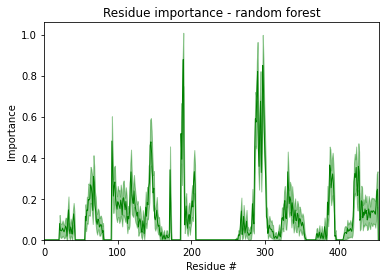

In [6]:
plt.plot(mean_residue_importance, color = 'green', linewidth = 1)
plt.fill_between(np.arange(len(mean_residue_importance)), \
                 mean_residue_importance + std_residue_importance, \
                 mean_residue_importance - std_residue_importance, \
                 color = 'green', alpha = 0.4)
plt.ylim(0)
plt.xlim(0, len(mean_residue_importance))
plt.title('Residue importance - random forest')
plt.xlabel('Residue #')
plt.ylabel('Importance')
plt.savefig('%s/%s.residue_importance_profile.png' %(output_image_dir, demyst_input), dpi = 500)

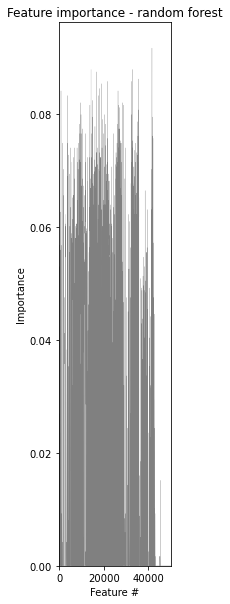

In [7]:
plt.figure(1, figsize= (2,10))
plt.plot(mean_feature_importance, linewidth = 0.2, color = 'grey')
plt.ylim(0)
plt.xlim(0,50000)
plt.xlabel('Feature #')
plt.ylabel('Importance')
plt.title('Feature importance - random forest')
plt.savefig('%s/%s.feature_importance_profile.png' %(output_image_dir, demyst_input), dpi = 500)

### Histogramming
You can select the bin # yourself which will change the filter size of your input

Will also obtain `max_features` which is taking from the furthest right bin of the histogram and we will use this for future calculations

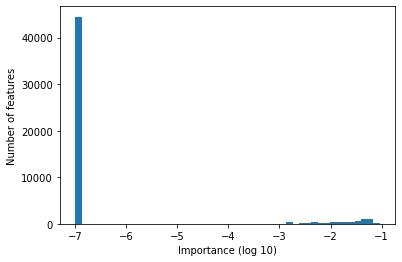

In [8]:
mean_feature_importance_logtrans = np.log10(mean_feature_importance + 0.0000001)   #some importances are zero, still need these, so make really small instead
custom_bins = np.linspace(np.min(mean_feature_importance_logtrans), np.max(mean_feature_importance_logtrans), bin_number) ## start at lowest
## possible value, end in highest, make as many bins as bin_number
feat_logtrans_histogram = plt.hist(mean_feature_importance_logtrans, bins = custom_bins)
max_features = np.where(mean_feature_importance_logtrans > feat_logtrans_histogram[1][-2])[0]   #finding the index
### of the features that are at the rightmost edge of the histogram (the feat_log_histogram[-1] will be 
### the top value, so nothing can be above that, need to take the secondmost top value)
plt.xlabel('Importance (log 10)')
plt.ylabel('Number of features')
plt.savefig('%s/%s.histogram_log10.%i_bins.png' %(output_image_dir, demyst_input, bin_number), dpi = 500)

### Feature importance profile revisited
plotting `max_features` onto the original feature importance

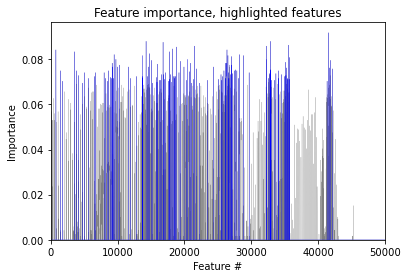

In [9]:
plt.plot(mean_feature_importance, color = 'grey', linewidth = 0.2)
zeros = np.zeros(np.shape(mean_feature_importance))
zeros[max_features] = mean_feature_importance[max_features]  #just masking over values that aren't in max_features
plt.plot(zeros, color = 'blue', linewidth = 0.2)
plt.xlim(0,50000)
plt.ylim(0)
plt.xlabel('Feature #')
plt.ylabel('Importance')
plt.title('Feature importance, highlighted features')
plt.savefig('%s/%s.feature_importance_profile.highlight_important.%i_bins.png' %(output_image_dir, demyst_input, bin_number), dpi = 500)


### Show distribution of max_features in residue distance plots

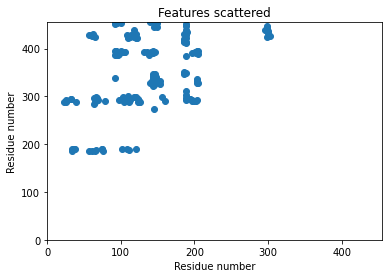

In [10]:
important_residue_pairs = feature_to_resids[max_features]
plt.scatter(important_residue_pairs[:,0], important_residue_pairs[:,1]) ## plot scatter of features, by x and y
plt.xlim(0, 455)
plt.ylim(0, 455)
plt.title('Features scattered')
plt.xlabel('Residue number')
plt.ylabel('Residue number')
plt.savefig('%s/%s.features_scattered.%i_bins.png' %(output_image_dir, demyst_input, bin_number) , dpi = 500)

# Clustering results from histogram

First make elbow plot to determine proper # clusters

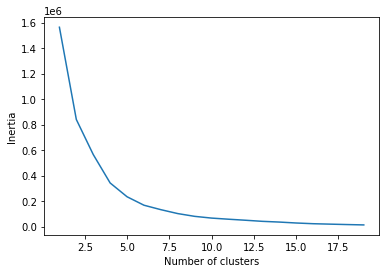

In [11]:
score = []
for i in range(1, 20):
    kmeans = sk.KMeans(n_clusters = i, init='k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(important_residue_pairs)
    score.append(kmeans.inertia_)

plt.plot(range(1,20), score)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('%s/%s.elbow_plot.%i_bins.png' %(output_image_dir, demyst_input, bin_number), dpi = 500)

Actual clustering, choose # clusters below. It's good to play with the output a bit. Set `save_images` to `False` if you are in playing mode and don't want to save all these pics 

In [12]:
save_images = True

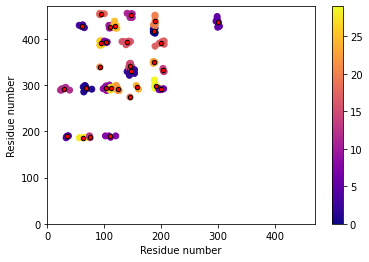

In [13]:
kmeans = sk.KMeans(n_clusters = n_clusters, init='k-means++', max_iter = 300, n_init = 10, random_state = 0)
pred_y = kmeans.fit_predict(important_residue_pairs) 
colormap = 'plasma'
plt.scatter(important_residue_pairs[:,0], important_residue_pairs[:,1], c = kmeans.labels_, cmap = colormap)   #plot residue plot again, labels are indexed same as residues, so can color by cluster 
plt.colorbar()
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=20, c = 'red', edgecolor = 'black')#np.arange(kmeans.n_clusters), cmap = colormap)  ## overlay cluster center onto residue plot
plt.xlim(0,470)
plt.ylim(0,470)
plt.xlabel('Residue number')
plt.ylabel('Residue number')

if save_images:
    plt.savefig('%s/cluster_plots/%s.%i_clusters.%i_bins.png' %(output_image_dir, demyst_input, n_clusters, bin_number), dpi = 500)

### Reporting cluster groups

There are situations where you might want to choose a residue pair in a cluster group that is not the centroid but the highest importance. Here you can see what residue pairs are in each cluster!

Each `cluster_location` is a list of the indices in max_features for which the clusters can be found. We access different aspects of these indices, most importantly to get the most important feature per cluster and save this into `collective_variables`

In [14]:
collective_variables_featureID = []
for res_cluster in range(0, n_clusters):    
    print('cluster number %i' %res_cluster)
    cluster_location = np.where(kmeans.labels_ == res_cluster)[0]
    for c in cluster_location:
        print('residue pair %s = feature %s. \n Importance %.4f and std %.4f' \
              %(important_residue_pairs[c], max_features[c],\
                mean_feature_importance[max_features[c]], std_feature_importance[max_features[c]]))  #labels is as long as max_clusters, so you can just index
        print()
        ### important_residue_pairs and max_features are the same variables in two different descriptions, features is the feature index, res is the residues corresponding to feature
        ### index. So you can then use max_features index to index again onto m_rf_feat (so #18 in max_features is == features 26811. Since m_rf_feat is an array of avg
        ### importances, you can index with 26811 and find corresponding importance)
    
    
    
    
    ### to get one pair with the most importance, have to go into the list
    if len(cluster_location) == 1:
        collective_variables_featureID.append(max_features[c])

        print('Only one CV in this cluster, appending %s to collective_variables'\
             %max_features[c])

    else:
        cluster_importance_list = mean_feature_importance[max_features[cluster_location]] # list of importances
        max_importance = int(np.where(max(cluster_importance_list) == cluster_importance_list)[0]) # one index, now not same as c

        collective_variables_featureID.append(max_features[cluster_location[max_importance]])

        print('Most important pair: %s, which is feature %s. Appending to collective_variables...' \
             %(important_residue_pairs[cluster_location[max_importance]], max_features[cluster_location[max_importance]]))



    
    print()
    print()
    print()

print('cluster centers = %s' %kmeans.cluster_centers_)

cluster number 0
residue pair [186 414] = feature 32278. 
 Importance 0.0779 and std 0.1203

residue pair [186 417] = feature 32281. 
 Importance 0.0774 and std 0.1352

residue pair [186 421] = feature 32285. 
 Importance 0.0724 and std 0.1374

residue pair [189 412] = feature 32837. 
 Importance 0.0753 and std 0.1328

residue pair [189 414] = feature 32839. 
 Importance 0.0699 and std 0.1159

residue pair [189 423] = feature 32848. 
 Importance 0.0715 and std 0.1155

Most important pair: [186 414], which is feature 32278. Appending to collective_variables...



cluster number 1
residue pair [ 63 296] = feature 8622. 
 Importance 0.0749 and std 0.1306

residue pair [ 64 285] = feature 8898. 
 Importance 0.0720 and std 0.1168

residue pair [ 65 288] = feature 9187. 
 Importance 0.0783 and std 0.1307

residue pair [ 66 299] = feature 9483. 
 Importance 0.0821 and std 0.1367

residue pair [ 67 297] = feature 9765. 
 Importance 0.0800 and std 0.1259

residue pair [ 68 293] = feature 10044.

 ---

### This is a good time to examine your CV picked and see that they look OK in the structure and as expected before moving on to the next section of this code

--- 

# Examining each of these CVs and outputting distances

- `use_demyst_for_dists` will most often be **`True`**
   - set this to __`False`__ if you have used different trajectories (eg. models, or different simulations) for demystifying, but want to use a different trajectory to plot distances. The # features __must be the same__ for both, but total simulation length can be different.
   - I used this when I was using In Open vs Out Open simulations as demystifying input, but want to see the distances of the CVs along all states for steered MD. 
   
   
- `distances` are distances you obtain in `preprocessing_CVs.py`. You may have normalized them for demystifying, but we don't want normalized distances, we need actual raw distances for the steered MD
   - They are as long as # frames in simulation, and as wide as # features
- `labels` are labels made for some of the supervised demystifying methods. Used in the CV plotting section to discern where each simulation starts and stops for `distances`
   - __NOTE__ it's always good to check that these distances are actually as expected

In [15]:
use_demyst_for_dists = False

if not use_demyst_for_dists:
    demyst_input_dir = '../../../GLUT5_atomistic/analysis/scripts/samples_features_arr'
    
distances = '%s/samples.clipped.ca.npy' %demyst_input_dir
labels = '%s/labels_all.npy' %demyst_input_dir

distances = np.load(distances)
labels = np.load(labels)

np.shape(labels)

(1910,)

We want to get the actual distances for these CVs, so we take the label indices for the simulations. This will be where `labels` changes from 0 --> 1 , 1 --> 2, etc

In [16]:
label_indices = np.where(labels[:-1] != labels[1:])[0]  #find where the label number doesn't match the following
label_indices = np.append(label_indices, -1)    ## Add a final index for outward open sims, so this will be taking the final frame later
label_indices = label_indices - 1  #just to be safe, in case final frame is weird for some reason, take second to last frame of simulation dists

Specific to my GLUT5 simulations, I want inward open gate to be at its most open for target CVs. See image:

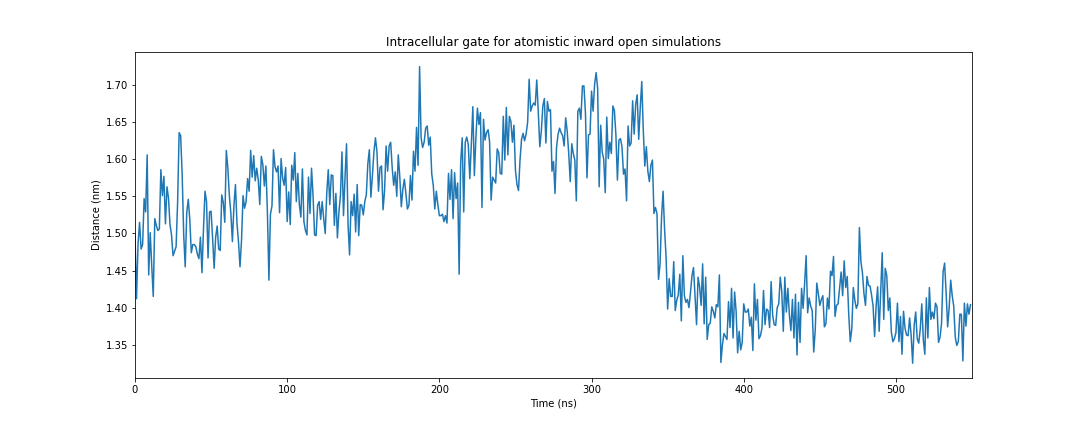

In [17]:
label_indices[0] = 303 

## Customizing CV picking & plots
Choose your names for your labeled simulations here.

Also access `collective_variables_featureID` to get `collective_variables_names`. We do this here because if you want to change any part of `collective_variables_featureID` (if you dont like one of the CVs or whatever...), the names will be consistent. 


Plot customization, can change figure size or colors
If you want random colors, set `random_colors` to **`True`**, otherwise it will color by residue pairing

Edit collective_variables_featureID here. can append, change certain values, etc. 

In [18]:
collective_variables_featureID = collective_variables_featureID

In [19]:
label_names = ['In Open', 'In Occluded', 'Occluded', 'Out Occluded', 'Out Open']
collective_variables_names = feature_to_resids[collective_variables_featureID]
collective_variables_names = list(map(tuple, collective_variables_names))

#adapt plot size - generally good to have it 15 x double length of CVs, just looks best I have found
figsize = (15, int(len(collective_variables_featureID)) *2)


# adapt color bar
random_colors = False
cmap = plt.cm.get_cmap('tab10')
if random_colors:
    np.random.seed(479)
    colors = cmap(np.random.random((int(len(collective_variables_featureID)))))[:,:-1]
else:
    color_by_featureID = collective_variables_featureID
    color_by_featureID = np.array(color_by_featureID)
    color_by_featureID = color_by_featureID / len(mean_feature_importance)
    colors = cmap(color_by_featureID)[:,:-1]

In [20]:
#np.where(np.all(feature_to_resids == [145, 401], axis = 1))
#feature_to_resids[1500]
np.where(feature_to_resids == 145)
np.where(feature_to_resids == 401)

(array([], dtype=int64), array([], dtype=int64))

### Make dataframes of distances and plot

Will also save images and save CSV of these CVs 

In [21]:
## not sure why you need the None but this will output # states by # cvs. Put directly into a dataframe!!
CV_distances = pd.DataFrame(distances[label_indices[:,None], collective_variables_featureID], \
            columns = collective_variables_names, index = label_names)
CV_distances.to_csv('./prep_steered/database.targetinfo.%s_CVs.csv' %len(collective_variables_featureID))
CV_distances

,"(186, 414)","(66, 299)","(153, 325)","(65, 424)","(33, 186)","(298, 443)","(202, 291)","(105, 393)","(108, 190)","(104, 295)",...,"(186, 430)","(92, 339)","(123, 294)","(189, 349)","(156, 299)","(118, 438)","(94, 396)","(112, 292)","(61, 186)","(189, 293)"
In Open,2.758591,2.329679,1.688404,0.793630,1.406782,2.690548,3.217253,3.333222,0.832200,3.098011,...,3.444143,3.858300,2.456298,3.094241,3.661659,3.207798,2.476617,2.274315,2.116887,1.768497
In Occluded,2.766006,2.497649,1.325797,0.674097,1.147981,2.252549,2.748917,2.932750,0.817791,2.970106,...,2.644003,3.542445,2.287610,3.239600,3.760153,3.524759,2.169375,2.818770,2.059905,1.589229
Occluded,3.344124,1.840749,1.040024,0.611412,1.744599,2.793217,2.982054,3.019668,1.380930,2.562112,...,3.813126,3.627110,2.385335,3.690383,3.303032,3.252619,2.061117,2.206132,2.985409,2.454072
Out Occluded,2.790828,2.555869,1.005605,1.305431,1.271558,2.728339,3.261567,2.954457,0.778789,3.218838,...,3.705504,3.347044,2.701940,3.462023,3.537507,3.506264,2.053992,2.657120,2.001059,2.197741
Out Open,3.121525,2.858212,0.939443,1.276418,1.719754,2.950805,3.904165,2.906255,1.394416,3.637982,...,4.316108,3.268890,2.831301,3.763180,3.863226,3.456381,1.916202,2.929612,2.499060,2.785494


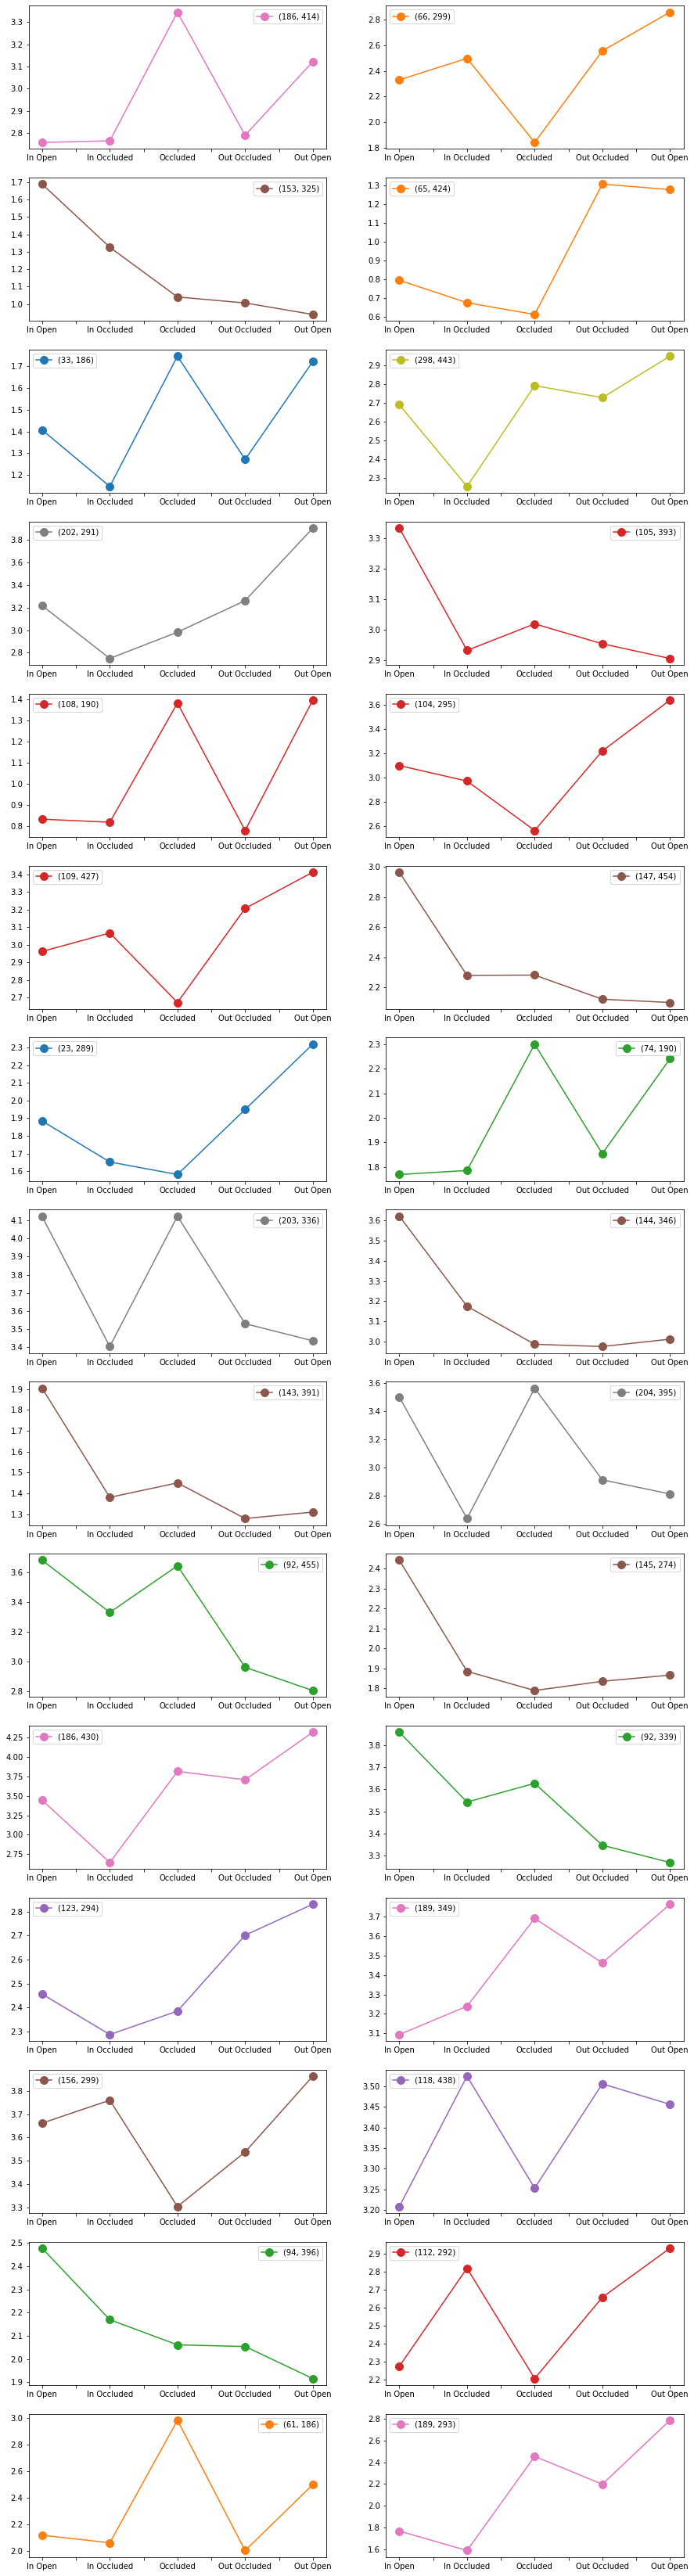

In [22]:
fig, axes = plt.subplots(math.ceil(len(collective_variables_featureID) / 2), 2, figsize=figsize)

#if not divisible by zero, delete the final axes
if len(collective_variables_featureID) % 2 != 0:
    fig.delaxes(axes[math.floor(len(collective_variables_featureID) / 2) , 1])
    
for i, cv_data in enumerate(CV_distances):
    ax = CV_distances[cv_data].plot(ax = axes.flatten()[i], style = '.-', markersize = 20, label = cv_data, color = tuple(colors[i]))
    ax.legend()    
    
plt.savefig('../images_figs/%s.CVs_feature_selector.%s_CVs.png' %(demyst_input, len(collective_variables_featureID)), dpi = 200)

### Maybe it's helpful to see all the distances throughout all atomistic simulations
Here we plot all distances, and mark where each frame is taken from for the CV picking

This is quite useful if you have a mashup of atomistic simulations like I do, because you might see that some things are big diffs in demystifying but they are actually fluctuating quite a bit

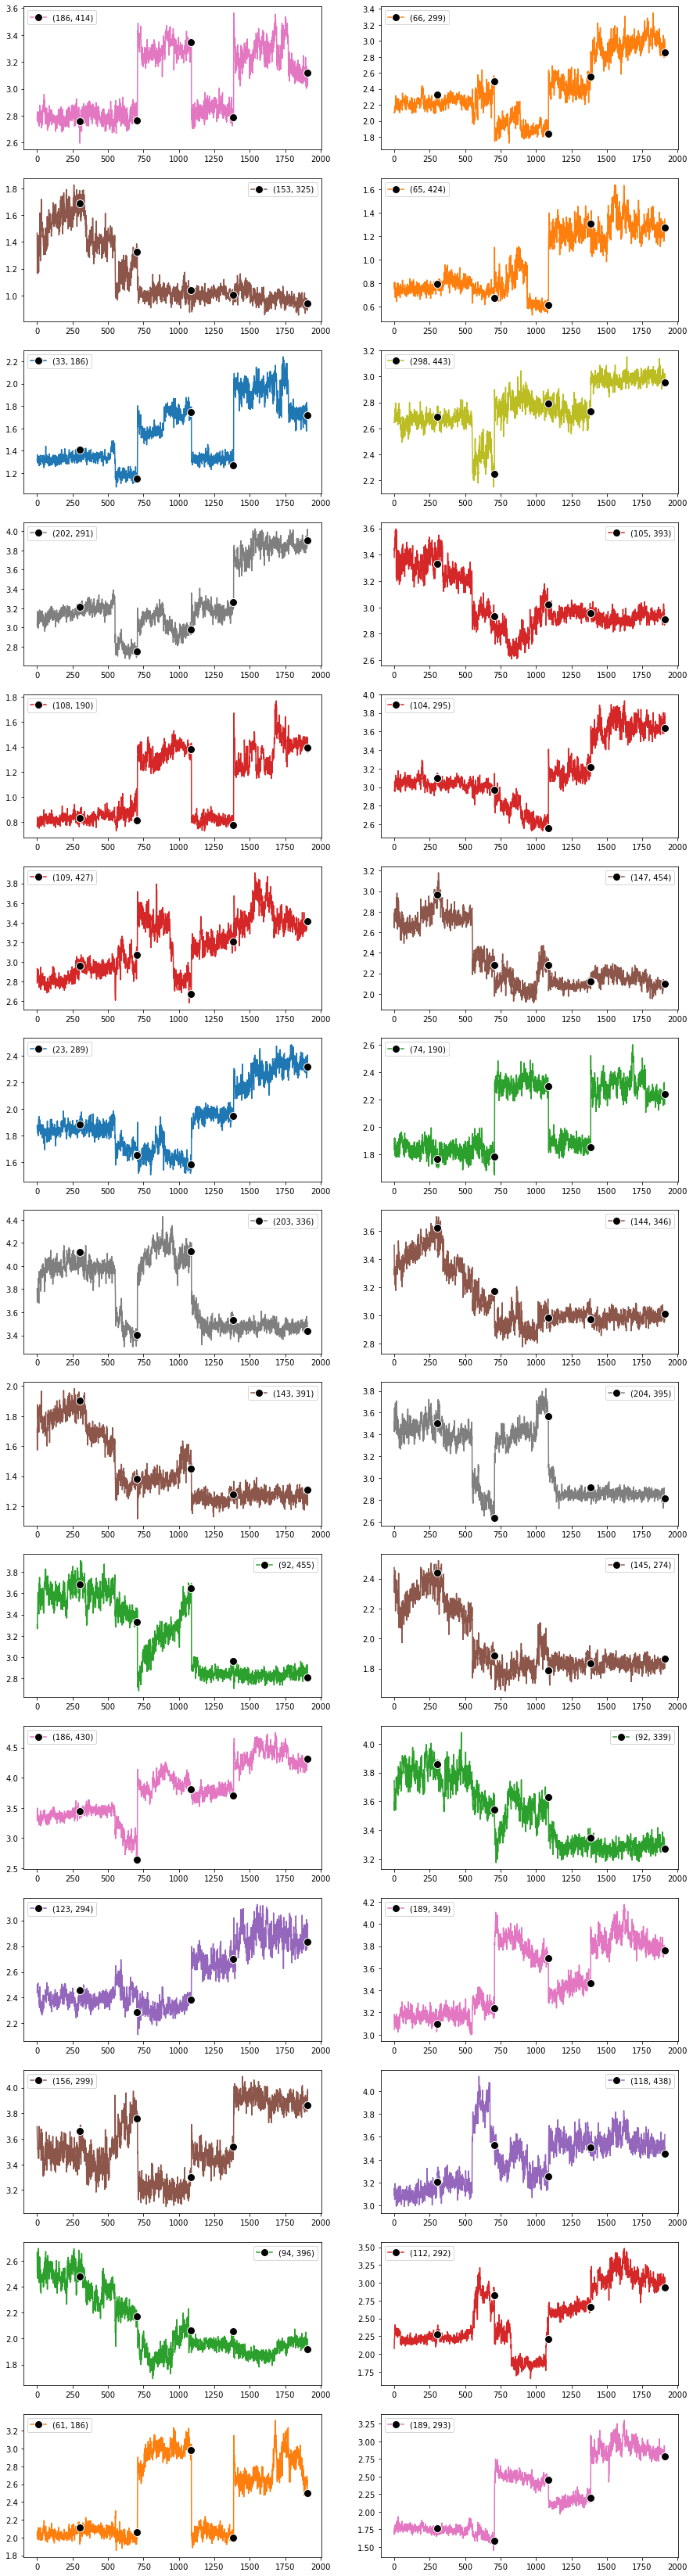

In [23]:
all_distances = pd.DataFrame(distances[:,collective_variables_featureID], \
            columns = collective_variables_names)


fig, axes = plt.subplots(math.ceil(len(collective_variables_featureID) / 2), 2, figsize=figsize)

#if not divisible by zero, delete the final axes
if len(collective_variables_featureID) % 2 != 0:
    fig.delaxes(axes[math.floor(len(collective_variables_featureID) / 2) , 1])
    
for i, cv_data in enumerate(all_distances):
    ax = all_distances[cv_data].plot(ax = axes.flatten()[i], \
                                    linestyle = '-', marker ='o',\
                                    markersize = 10, label = cv_data, \
                                    markevery = label_indices, markerfacecolor = 'black', \
                                    markeredgecolor = 'white', figsize = figsize, color = tuple(colors[i]))
    ax.legend()  

plt.savefig('../images_figs/%s.CVs_feature_selector_all_dists.%s_CVs.png' %(demyst_input, len(collective_variables_featureID)), dpi = 200)

# Making this for input_maker.ipynb

For `input_maker` you will need a dictionary of the residue # (or whatever you want to name your feature) as a key, with the atom # as the value. The code here will automate this for you.

### User inputs:
`pdb` - ensure that you have the GRO file you will steer from. This may be different from the PDB you use for demystifying but it __must not__ be different in residue #'s. 
   - For the case of GLUT5, they are different files, but same residue #'s. The index is however different (because GLUT5 for demystifying skipped some loop regions)

In [24]:
pdb = md.load('./prep_steered/GLUT5_in.303ns.gro')
top = pdb.topology

#first get unique IDs for repeats, common with more CVs or very important features
names_flattened = list(sum(collective_variables_names,()))
names_flattened_unique = []
for i, v in enumerate(names_flattened):
    totalcount = names_flattened.count(v)
    count = names_flattened[:i].count(v)
    v = str(v)
    names_flattened_unique.append(v + '_' + str(count + 1) if totalcount > 1 else v)
    

# put these into a dict
ndx_groups = {}
for resid in names_flattened_unique: 
    ndx_groups['r_%s' %resid] = 'bynum %i' %(int(top.select('protein and (name CA and residue %i)' %(int(resid.split('_')[0]))) + 1)) # 0 indexing, but gmx starts at 1

It's __very important__ you check these ndx groups that they are correct, and also that they are in the order you wish. (it should be cv0, cv0, cv1, cv1, cv2, cv2...)

If everything is OK, can just paste this into the `input_maker` session

In [25]:
ndx_groups

{'r_186_1': 'bynum 2884',
 'r_414': 'bynum 6490',
 'r_66': 'bynum 1037',
 'r_299_1': 'bynum 4729',
 'r_153': 'bynum 2383',
 'r_325': 'bynum 5094',
 'r_65': 'bynum 1026',
 'r_424': 'bynum 6656',
 'r_33': 'bynum 485',
 'r_186_2': 'bynum 2884',
 'r_298': 'bynum 4710',
 'r_443': 'bynum 6956',
 'r_202': 'bynum 3121',
 'r_291': 'bynum 4589',
 'r_105': 'bynum 1646',
 'r_393': 'bynum 6166',
 'r_108': 'bynum 1687',
 'r_190_1': 'bynum 2953',
 'r_104': 'bynum 1625',
 'r_295': 'bynum 4653',
 'r_109': 'bynum 1706',
 'r_427': 'bynum 6707',
 'r_147': 'bynum 2280',
 'r_454': 'bynum 7152',
 'r_23': 'bynum 333',
 'r_289': 'bynum 4549',
 'r_74': 'bynum 1168',
 'r_190_2': 'bynum 2953',
 'r_203': 'bynum 3140',
 'r_336': 'bynum 5289',
 'r_144': 'bynum 2239',
 'r_346': 'bynum 5442',
 'r_143': 'bynum 2220',
 'r_391': 'bynum 6127',
 'r_204': 'bynum 3161',
 'r_395': 'bynum 6195',
 'r_92_1': 'bynum 1431',
 'r_455': 'bynum 7164',
 'r_145': 'bynum 2246',
 'r_274': 'bynum 4336',
 'r_186_3': 'bynum 2884',
 'r_430': 

In [26]:
label_indices

array([ 303,  706, 1087, 1385,   -2])